- *It works!*
- DONE: use `max_batchsize` from `utils`
- DONE: make **dedicated notebook** to (i) compare `conll2003` to `fewnerd` and (ii) to bring `fewnerd` into the same format.
- DONE: use fewnerd
- DONE: get total flops count with **einops**
- DONE: make custom splits
- DONE: reorder the notebook cells:
  - DONE: model (LoRA) and tokenizer (save peftconfig if necessary)
  - DONE: dataset etc
  - DONE: training, metrics and saving (tokenizer and model)
  - DONE: inference via loading saved items (probably tokenizer, model and peftconfig – OR follow this [guide](https://huggingface.co/docs/peft/v0.9.0/en/package_reference/lora#peft.LoraModel))
- DONE: In **Using the fine-tuned model**, [merge and unload](https://huggingface.co/docs/peft/v0.6.2/en/package_reference/tuners#peft.LoraModel.merge_and_unload) or [reinstantiate](https://huggingface.co/docs/peft/v0.6.2/en/task_guides/token-classification-lora#inference) the LoRA model!
- DONE: adjust batch size – and if necessary epochs – for 3000 training steps `num_steps = train_instances*epochs/batch_size` $\geq$ 3000 $\Rightarrow$ `batch_size` $\leq$ `train_instances*epochs/3000 = train_instances/1000` $\Rightarrow$ `batch_size` $\leq$ `train_instances / 1000` for `epochs = 3`<br>DONE: But do it like this:
  - DONE: get max batch size for model (= max_batchsize_by_model)
  - DONE: specify trainig split
  - DONE: get max batch size for training split length (=max_batchsize_by_trainsplit)
  - DONE: impose max batch size of 32
  - DONE: the batch size is the minimum of these three numbers
- DONE: build `results.json` (consider pandas series) via dict. It holds: splits, specified loraconfig details, flops, metrics (per epoch)
- DONE: use the uuid library to save `results.json` under `results_{uuid}.json`
- DONE: declare variable `split` and use it to select splits as well as for logging it in `results_{uuid}.json`.
- DONE: use split `dev` and determine the learning rate for LoRA models. It seems that with `accelerate`, the maximum accepted learning rate is `5e-4` since fails for higher learning rates.
- DONE: outside the training loop make a dummy classification report using scikit-learn with dummy labels and dummy predictions (both formatted as required by classification report)
- DONE: at the end of each epoch, bring the labels and predictions into the required format
- DONE: write a compute metrics function that returns a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) as dict, then log the relevant values
- DONE: drop the `uuid` from the `logs_dict` filename as it only adds ambiguity about what file to look at.
- DONE: Use both `macro` and `weighted` metrics.
- DONE: Specify `output_dir` with `spec` (e.g. `ner_logs/fb-roberta/{spec}`) for saving `logs_dict.json` and `confusion_matrix.png`:
  - DONE: pattern: `task/model/spec/*files_with_vanilla_names*`
  - DONE: example: `ner_logs/FacebookAI-roberta-large/split=dev__r=64__bias=lora_only__loradroput=0point2/logs_dict.json`
- DONE: Add confusion matrix
  - DONE: save percentage version
  - DONE: save vanilla version
- DONE: Save `logs_dict.json` and `confusion_matrix.png`.
- DONE: keep original ner labels (IOB2 would result in 2*n-1 labels instead of n labels – but due to sparse labels, the dataset is already difficult enough)
- DONE: filter out long instances with 80 words or more $\Rightarrow$ remove 0.3384% of training instances (negligible).
- Drop accelerate and use basic torch loop as in `roberta-base-ner_LoRA_cells.ipynb` (make a copy of that other notebook and adapt it to this one.
- Pick a not too long instance from `fewnerd_all_processed` and show token - label pairs (as for inference).
- Handle and log both `roberta-large` and `roberta-base` (adapt `batch_size_dict`).
- Check once more the wandb [ablation study](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU) on batch sizes!
- check everything once more
- add comments
- make new notebook copy for sweep

# NER with `fewnerd` and LoRA

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
import os
import re
import json
import time
import torch
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt

from peft import LoraConfig, TaskType, PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
from utils import set_seed, smoothen_list, make_confusion_matrix
from dotenv import load_dotenv
from datasets import load_dataset, concatenate_datasets, DatasetDict
from evaluate import load
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler, pipeline, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from huggingface_hub import login
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from deepspeed.profiling.flops_profiler import FlopsProfiler

load_dotenv()
login(token=os.getenv("HUGGINGFACE_API_KEY"))
logs_dict = {}
logs_dict["seed"] = set_seed(42)

[2024-04-16 11:22:50,226] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/matthias/.cache/huggingface/token
Login successful
All random seeds set to 42.


## Model

In [4]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
print(label_names)
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product']


({'0': 'O',
  '1': 'art',
  '2': 'building',
  '3': 'event',
  '4': 'location',
  '5': 'organization',
  '6': 'other',
  '7': 'person',
  '8': 'product'},
 {'O': '0',
  'art': '1',
  'building': '2',
  'event': '3',
  'location': '4',
  'organization': '5',
  'other': '6',
  'person': '7',
  'product': '8'})

In [5]:
model_version = "base" # "base" or "large"
model_id = f"FacebookAI/roberta-{model_version}" # "FacebookAI/roberta-base" or "FacebookAI/roberta-large"
logs_dict["model_id"] = model_id
model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
# LoRA model
# datasets:      3 values [1%, 10%, 100%]
# lora_rank:    10 values [1, ..., 512]
# lora_dropout:  5 values [0, 0.1, 0.2, 0.3, 0.4]
# lora_bias:     3 values ["all", "none", "lora_only"]
# => 3 x 10 x 5 x 3 = 450 sweeps per notebook (of which 45 have rank 512 and thus take 45*3.75h=168.75 > 168h=7*24h => a bit over two weeks
# => start with 2 dataset values (10%, 100%) and 3 rank values (2, 8, 32) => 6 sweeps
LoRA_params_dict = {
    "r": 128,
    "target_modules": ["query", "key", "value", "query_proj", "key_proj", "value_proj"],
    "bias": "all",
    "use_rslora": True,
    "task_type": TaskType.TOKEN_CLS,
    "lora_dropout": 0.2
}
logs_dict["LoRA_params_dict"] = LoRA_params_dict
# base
# r = 512 => (28420617, 152380434, 0.18651)
# large
# r =   1 => (  156681, 354476050, 0.00044)
# r =   2 => (  304137, 354623506, 0.00086)
# r =   4 => (  599049, 354918418, 0.00169)
# r =   8 => ( 1188873, 355508242, 0.00334)
# r =  16 => ( 2368521, 356687890, 0.00664)
# r =  32 => ( 4727817, 359047186, 0.01317)
# r =  64 => ( 9446409, 363765778, 0.02597)
# r = 128 => (18883593, 373202962, 0.0506)
# r = 256 => (37757961, 392077330, 0.0963)
# r = 512 => (75506697, 429826066, 0.17567)
config = LoraConfig(
    # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
    # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
    # https://arxiv.org/abs/2312.03732, 
    r = LoRA_params_dict["r"],
    target_modules=LoRA_params_dict["target_modules"],
    bias=LoRA_params_dict["bias"],
    use_rslora=LoRA_params_dict["use_rslora"],
    task_type=LoRA_params_dict["task_type"],
    lora_dropout=LoRA_params_dict["lora_dropout"]
)
logs_dict["LoraConfig"] = str(config)
print(f"LoRA config:\n{config}\n")
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
print(f"base_model type:\n{type(model)}")
print(f"\nadapter_model type:\n{type(model)}")
trainable_params, all_params = model.get_nb_trainable_parameters()
trainable_fraction = round(trainable_params/all_params, 5)
logs_dict["LoRA_model_trainable_params"] = trainable_params
logs_dict["LoRA_model_all_params"] = all_params
logs_dict["LoRA_model_trainable_fraction"] = trainable_fraction
print(f"\ntrainable parameters:\n{trainable_params}")
print(f"\nall parameters:\n{all_params}")
print(f"\ntrainable fraction:\n{trainable_fraction}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA config:
LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=128, target_modules={'query_proj', 'value', 'value_proj', 'key', 'key_proj', 'query'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

base_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

adapter_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

trainable parameters:
7186953

all parameters:
131146770

trainable fraction:
0.0548


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
logs_dict["tokenizer"] = model_id
print(f"tokenizer is fast: {tokenizer.is_fast}")
tokenizer

tokenizer is fast: True


RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

## Dataset

In [7]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 131767
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 18824
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 37648
    })
})

In [8]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word and word_id!=None:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

fewnerd_all_processed = (
    concatenate_datasets([raw_datasets["train"], raw_datasets["validation"], raw_datasets["test"]])
    # pre-tokenization, the "tokens" column contains words (not tokens)
    .filter(lambda example: len(example["tokens"])<=30) # 80 => from 188239 to 187602 (637 instances or 0.3384% removed) fail
                                                        # 50 => 181338 (6901 instances or 3.6661% removed) fail
                                                        # 49 => 180656 (7583 instances or 4.0284% removed) success
                                                        # 48 => 179938 (8301 instances or 4.4098% removed) success
                                                        # 47 => 179097 (9142 instances or 4.8566% removed) success
                                                        # 45 => 177164 (11075 instances or 5.8835% removed) success
                                                        # 40 => 169934 (18305 instances or 9.7243% removed) success
                                                        # 30 => 141195 (47044 instances or 24.9916% removed) success
    .map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )
)
fewnerd_all_processed

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 141195
})

In [9]:
# filter dataset by length if necessary
trainvalid_test_splits = fewnerd_all_processed.train_test_split(test_size=0.15)
test_split_100 = trainvalid_test_splits["test"]
test_split_10 = test_split_100.train_test_split(test_size = 0.1)["test"]
test_split_1 = test_split_100.train_test_split(test_size = 0.01)["test"]
trainvalid_split = trainvalid_test_splits["train"]
train_valid_split = trainvalid_split.train_test_split(test_size=0.15)
valid_split_100 = train_valid_split["test"]
valid_split_10 = valid_split_100.train_test_split(test_size = 0.1)["test"]
valid_split_1 = valid_split_100.train_test_split(test_size = 0.01)["test"]
train_split_100 = train_valid_split["train"]
train_split_10 = train_split_100.train_test_split(test_size = 0.1)["test"]
train_split_1 = train_split_100.train_test_split(test_size = 0.01)["test"]
dev_train_split = train_split_100.train_test_split(test_size = 120)["test"]
dev_valid_split = valid_split_100.train_test_split(test_size = 32)["test"]
dev_test_split = test_split_100.train_test_split(test_size = 8)["test"]
fewnerd_dsd = DatasetDict({
    "train_100": train_split_100,
    "train_10": train_split_10,
    "train_1": train_split_1,
    "valid_100": valid_split_100,
    "valid_10": valid_split_10,
    "valid_1": valid_split_1,
    "test_100": test_split_100,
    "test_10": test_split_10,
    "test_1": test_split_1,
    "train_dev": dev_train_split,
    "valid_dev": dev_valid_split,
    "test_dev": dev_test_split
})
fewnerd_dsd

DatasetDict({
    train_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 102012
    })
    train_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10202
    })
    train_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1021
    })
    valid_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18003
    })
    valid_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1801
    })
    valid_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 181
    })
    test_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21180
    })
    test_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2118
    })
    test_1: Dataset({
        features: ['input_ids', 'attentio

In [10]:
split = "dev" # "100", "10", "1", "dev"
assert split in ("100", "10", "1", "dev"), f"Split '{split}' is not a valid choice."
train_split = f"train_{split}"
valid_split = f"valid_{split}"
test_split = f"test_{split}"
train_split, valid_split, test_split

('train_dev', 'valid_dev', 'test_dev')

In [11]:
# idx = 4 # 9, 36
# input_ids_idx = fewnerd_dsd[train_split][idx]["input_ids"]
# labels_idx = fewnerd_dsd[train_split][idx]["labels"]
# tokens_idx = [tokenizer.decode(input_id_idx) for input_id_idx in input_ids_idx]
# print(f"input_ids (len):\n{input_ids_idx} ({len(input_ids_idx)})") #\nlabels (len):\n{labels_idx} ({len(labels_idx)})")
# print(f"labels (len):\n{labels_idx} ({len(labels_idx)})")
# print(f"tokens (len):\n{tokens_idx} ({len(tokens_idx)})")

In [12]:
spec = f"split={split}"
spec += f"__r={LoRA_params_dict['r']}"
spec += f"__bias={LoRA_params_dict['bias']}"
spec += f"__loradroput=0point{str(LoRA_params_dict['lora_dropout'])[2:]}"
model_folder = re.sub("/", "-", model_id)
output_dir = f"ner_logs/{model_folder}/{spec}"
output_dir

'ner_logs/FacebookAI-roberta-base/split=dev__r=128__bias=all__loradroput=0point2'

## Training

In [13]:
batchsize_dict = {
    "100": 32,
    "10": 8,
    "1": 1,
    "dev": 2
}
batch_size = batchsize_dict[split]
logs_dict["batch_size"] = batch_size
batch_size

2

In [14]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple

In [15]:
batch = data_collator([fewnerd_dsd[train_split][i] for i in [0, 1]])
batch["labels"] # As we can see, the second set of labels has been padded to the length of the first one using -100s.

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    7,    7,    7,    0,    0,    7,    7,    7,    0,    0,    0,
            7,    7,    0,    0,    1,    1,    1,    1,    1,    1,    1,    0,
            0, -100],
        [-100,    0,    0,    0,    0,    0,    0,    4,    4,    4,    4,    4,
            0,    0,    4,    4,    4,    0, -100, -100, -100, -100, -100, -100,
         -100, -100]])

In [16]:
train_dataloader = DataLoader(
    fewnerd_dsd[train_split],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)
valid_dataloader = DataLoader(fewnerd_dsd[valid_split], collate_fn=data_collator, batch_size=batch_size)
train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x708d9010feb0>,
 <torch.utils.data.dataloader.DataLoader at 0x708d9010d630>)

In [17]:
optimizer = AdamW(model.parameters(), lr=1e-3)
accelerator = Accelerator()
model, optimizer, train_dataloader, valid_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
    valid_dataloader
)
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
logs_dict["num_training_steps"] = num_training_steps
num_warmup_steps = min(500, round(0.15 * num_update_steps_per_epoch)) # 500 or 15% of one epoch, whichever is less
logs_dict["num_warmup_steps"] = num_warmup_steps
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
print(f"training_steps (all epochs):\t{num_training_steps}\nnum_warmup_steps (first epoch):\t{num_warmup_steps}")

training_steps (all epochs):	180
num_warmup_steps (first epoch):	9


In [18]:
def flatten_list_of_lists(list_of_lists):
    flattened_list = []
    for list_i in list_of_lists:
        list_i = list_i.tolist() # handle tensors in case list_of_lists is a list of tensors
        list_i = list(itertools.chain.from_iterable(list_i)) # flatten list_i using the standard library
        flattened_list += list_i
    return flattened_list

def compute_metrics(y_true, y_pred, average_type):
    metrics_dict = classification_report(y_true, y_pred, digits=6, output_dict=True, zero_division=0.0)
    accuracy = metrics_dict["accuracy"]
    avg_dict = metrics_dict[average_type]
    avg_dict["accuracy"] = accuracy
    # https://stackoverflow.com/questions/52139110/how-to-change-the-order-of-keys-in-a-python-3-5-dictionary-using-another-list-a
    avg_dict_order = {k : avg_dict[k] for k in ["accuracy", "precision", "recall", "f1-score", "support"]}
    avg_dict_order["support"] = round(avg_dict_order["support"])
    metrics = [f"{key}: {avg_dict_order[key]}" for key in avg_dict_order.keys()]
    return metrics

prof = FlopsProfiler(model) # deepspeed profiler
flops_list = []
loss_list = []
training_start = True
validation_start = True
progress_bar = tqdm(range(num_training_steps))
start_time = time.time() # start time
for epoch in range(num_train_epochs):
    # Training
    model.train()
    prof.start_profile() # start profiling
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        loss_list.append(loss.item())
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        if training_start:
            print("\ntraining")
            print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
            print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
            training_start = False
        optimizer.zero_grad()
        progress_bar.update(1)
    prof.stop_profile() # stop profiling
    total_flops = prof.get_total_flops()
    flops_list.append(total_flops)
    # Validation
    model.eval()
    epoch_predictions = []
    epoch_labels = []
    for batch in valid_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        if validation_start:
            print("validation")
            print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
            print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
            validation_start = False
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        assert len(predictions)==len(labels)
        epoch_predictions.append(predictions)
        epoch_labels.append(labels)
    # collect both, labels and predictions, in one big list each
    flat_epoch_labels = flatten_list_of_lists(epoch_labels)
    flat_epoch_predictions = flatten_list_of_lists(epoch_predictions)
    # get classification report, then log and print results
    metrics_macro = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "macro avg")
    metrics_weighted = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "weighted avg")
    logs_dict[f"epoch_{epoch}_metrics_macro"] = metrics_macro
    logs_dict[f"epoch_{epoch}_metrics_weighted"] = metrics_weighted
    print(f"\nepoch {epoch}\nmetrics_macro\n{metrics_macro}\nmetrics_weighted\n{metrics_weighted}")
    # save model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir)
    # save tokenizer
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
#
stop_time = time.time()
training_loop_time = str(datetime.timedelta(seconds = round(stop_time-start_time)))
print(f"\ntraining loop time: {training_loop_time}")
logs_dict["training_loop_time"] = training_loop_time
prof.end_profile() # end profiling
logs_dict["flops_list"] = flops_list
print(flops_list)
flops_array = np.array(flops_list)
np.sum(flops_array), np.mean(flops_array)

  0%|          | 0/180 [00:00<?, ?it/s]

[2024-04-16 11:22:58,168] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



training
['input_ids shape: [2, 35]', 'attention_mask shape: [2, 35]', 'labels shape: [2, 35]']
logits shape: [2, 35, 9], loss: 2.094644069671631

validation
['input_ids shape: [2, 33]', 'attention_mask shape: [2, 33]', 'labels shape: [2, 33]']
logits shape: [2, 33, 9], loss: 0.8108165860176086


epoch 0
metrics_macro
['accuracy: 0.5974477958236659', 'precision: 0.1544604570373989', 'recall: 0.232112669872006', 'f1-score: 0.14660976841881362', 'support: 862']
metrics_weighted
['accuracy: 0.5974477958236659', 'precision: 0.420288391024384', 'recall: 0.5974477958236659', 'f1-score: 0.47276636191675425', 'support: 862']
[2024-04-16 11:23:14,437] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 1
metrics_macro
['accuracy: 0.6345707656612529', 'precision: 0.2440990109744684', 'recall: 0.34836094653281496', 'f1-score: 0.2733699225136996', 'support: 862']
metrics_weighted
['accuracy: 0.6345707656612529', 'precision: 0.442308543235269', 'recall: 0.6345707656612529', 'f1-score: 0.5144000881845546', 'support: 862']
[2024-04-16 11:23:29,565] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 2
metrics_macro
['accuracy: 0.6566125290023201', 'precision: 0.38993917427191654', 'recall: 0.3932752378239178', 'f1-score: 0.3384403019982792', 'support: 862']
metrics_weighted
['accuracy: 0.6566125290023201', 'precision: 0.46897609557021225', 'recall: 0.6566125290023201', 'f1-score: 0.5390457815374453', 'support: 862']

training loop time: 0:00:47
[2024-04-16 11:23:45,300] [INFO] [profiler.py:226:end_profile] Flops profiler finished
[112034756928, 111655156416, 109920606720]


(333610520064, 111203506688.0)

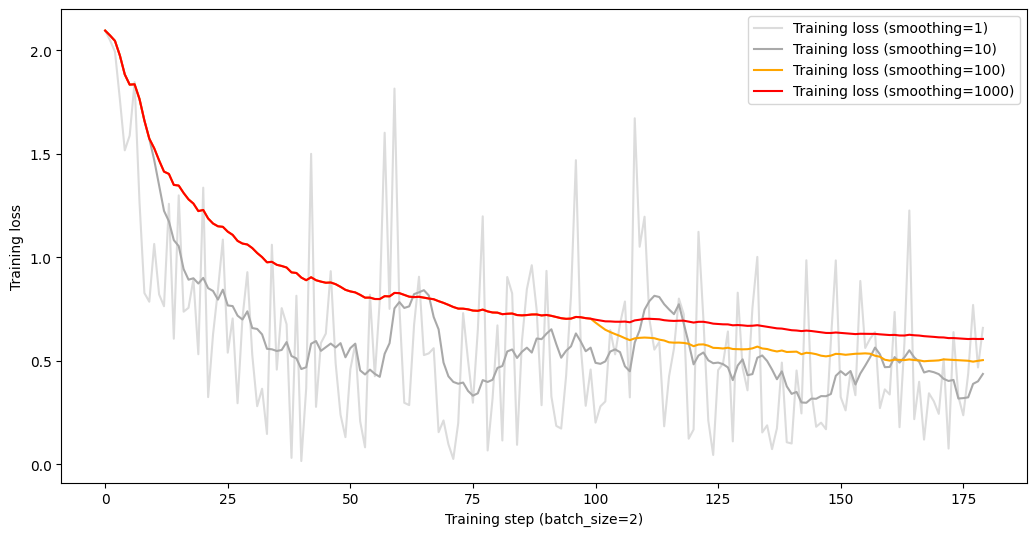

In [19]:
# smoothen loss_list and add show according line to plot (also save plot)
plt.figure(figsize=(10, 5))
colors = ["gainsboro", "darkgray", "orange", "red"]
for i, smoothing_n in enumerate([1, 10, 100, 1000]):
    smoothened_loss = smoothen_list(loss_list, smoothing_n)
    plt.plot(smoothened_loss, colors[i], label=f"Training loss (smoothing={smoothing_n})")
legend = plt.legend(loc="upper right", shadow=False)
plt.tight_layout(pad=.1)
plt.xlabel(f"Training step (batch_size={batch_size})")
plt.ylabel("Training loss")
plt.savefig(f"{output_dir}/training_loss_plot.png")
plt.show()

/home/matthias/Desktop/Compute-Optimal_LoRA-Adapters_for_Language_Models/utils.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  conf_matrix[i] *= 100/np.sum(conf_matrix[i])
/home/matthias/Desktop/Compute-Optimal_LoRA-Adapters_for_Language_Models/utils.py:75: RuntimeWarning: invalid value encountered in multiply
  conf_matrix[i] *= 100/np.sum(conf_matrix[i])


confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-base/split=dev__r=128__bias=all__loradroput=0point2/confusion_matrix_pct.png
confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-base/split=dev__r=128__bias=all__loradroput=0point2/confusion_matrix_abs.png


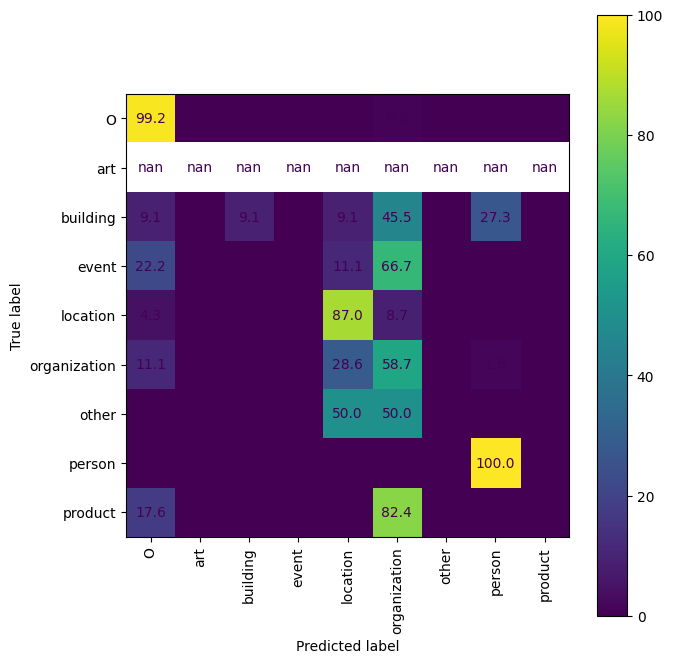

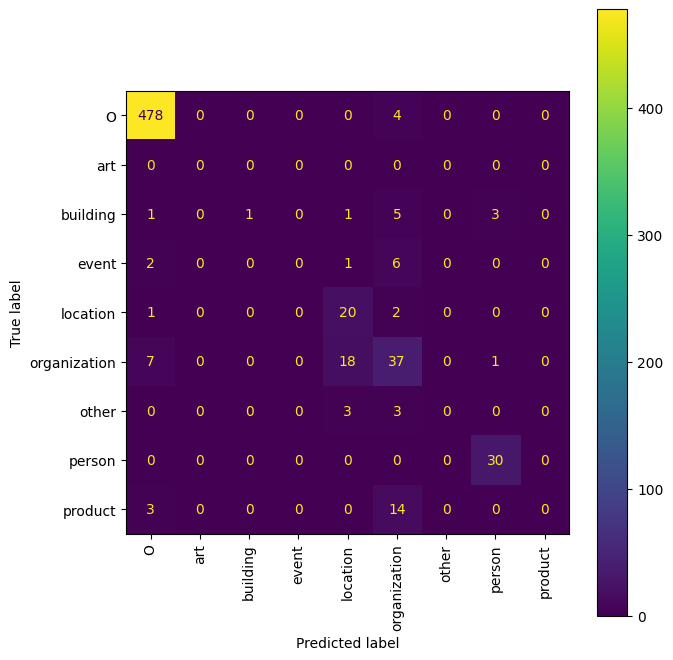

In [20]:
flat_epoch_labels_without_special_tokens = []
flat_epoch_predictions_without_special_tokens = []
for i in range(len(flat_epoch_labels)):
    label_i = flat_epoch_labels[i]
    prediction_i = flat_epoch_predictions[i]
    if label_i!=-100:
        flat_epoch_labels_without_special_tokens.append(label_i)
        flat_epoch_predictions_without_special_tokens.append(prediction_i)
# plot and save confusion matrices
for percentage in [True, False]:
    make_confusion_matrix(
        flat_epoch_labels_without_special_tokens,
        flat_epoch_predictions_without_special_tokens,
        label_names,
        percentage=percentage,
        output_dir=output_dir
    )

## Save logs and reload model for inference

In [21]:
with open(f"{output_dir}/logs_dict.json", "w") as outfile: 
	json.dump(logs_dict, outfile, indent=2)
logs_dict

{'seed': 42,
 'model_id': 'FacebookAI/roberta-base',
 'LoRA_params_dict': {'r': 128,
  'target_modules': ['query',
   'key',
   'value',
   'query_proj',
   'key_proj',
   'value_proj'],
  'bias': 'all',
  'use_rslora': True,
  'task_type': <TaskType.TOKEN_CLS: 'TOKEN_CLS'>,
  'lora_dropout': 0.2},
 'LoraConfig': "LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=128, target_modules={'query_proj', 'value', 'value_proj', 'key', 'key_proj', 'query'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})",
 'LoRA_model_trainable_params': 7186953,
 'LoRA_model_all_params': 131146770,
 'LoRA_model_trainable_fraction': 0.0548,
 'tokenizer': '

In [22]:
# load inference model
config = PeftConfig.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
inference_model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
inference_model = PeftModel.from_pretrained(inference_model, output_dir).merge_and_unload()
print(f"type(inference_model):\n{type(inference_model)}\n")
# get inputs from text (source: https://en.wikipedia.org/wiki/Konstanz#History)
text = "Konstanz was the birthplace of Count Ferdinand von Zeppelin, constructor of the famous Zeppelin airships."
inputs = tokenizer(text, return_tensors="pt")
inputs

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/matthias/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:71: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


type(inference_model):
<class 'transformers.models.roberta.modeling_roberta.RobertaForTokenClassification'>



{'input_ids': tensor([[    0, 11272, 22398,   329,    21,     5, 32357,     9, 12440, 28855,
          5689, 10915, 38042,     6, 47073,     9,     5,  3395, 10915, 38042,
           935, 31404,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [23]:
# inference
with torch.no_grad():
    logits = inference_model(**inputs).logits
tokens = inputs.tokens()
predictions = torch.argmax(logits, dim=2)
print(f"token (prediction)\n")
for token, prediction in zip(tokens, predictions[0].numpy()):
    print(f"{token} ({id2label[str(prediction)]})")

token (prediction)

<s> (O)
ĠKon (person)
stan (location)
z (location)
Ġwas (O)
Ġthe (O)
Ġbirthplace (O)
Ġof (O)
ĠCount (person)
ĠFerdinand (person)
Ġvon (person)
ĠZe (person)
ppelin (person)
, (O)
Ġconstructor (O)
Ġof (O)
Ġthe (O)
Ġfamous (O)
ĠZe (organization)
ppelin (organization)
Ġair (O)
ships (O)
. (O)
</s> (O)


$\checkmark$